In [1]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.signal import butter, filtfilt
import stumpy

# These 3 lines allow editing of the utils file without having to restart the Jupyter kernel.
%reload_ext autoreload
%autoreload 1
%aimport utils
import utils

# Better plotting.
%matplotlib ipympl

In [2]:
# Constants related to .mat structs.
CAI_SB1 = "caillouSB1_1117.mat"
BLUE_SB2 = "blueSB2_0328.mat"
BLUE_LFP0_IDX = ["RSX", "RSX", "", "", "SMX", "SMX", "SMX", "SMX"]
BLUE_LFP1_IDX = ["SMX", "SMX", "HIP", "", "", "RSX", "RSX", "RSX"]
CAI_SB1_LFPJ_IDX = ["THA", "THA", "RSX", "RSX", "RSX", "RSX", "RSX", "RSX"]
CAI_SB1_LFPK_IDX = ["RSX", "RSX", "RSX", "RSX", "RSX", "RSX", "HIP", "HIP"]
CAI_SB1_LFP0_IDX = ["HIP"]*8
LFP_NAMES = ["adlfpj", "adlfpk", "arlfp0", "arlfp1"]

# Hippocampus bandpass filter params.
HC_FILTER_LOW = 100
HC_FILTER_HI = 250
HC_FILTER_ORDER = 9

In this notebook, we'll try two methods of k-complex identification using the data from `blueSB2_0328.mat`. First load all data and do some basic preprocessing.

In [3]:
# load lfp
blue_struct = loadmat(BLUE_SB2, struct_as_record=False)
time, data0, sample_rate = utils.get_data(blue_struct, name=LFP_NAMES[2])  # LFP0
_, data1, _ = utils.get_data(blue_struct, name=LFP_NAMES[3])  # LFP1

# load FR
smxfr_time = np.squeeze(blue_struct["SMXfr"][0][0].timestamp)
smxfr_count = np.squeeze(blue_struct["SMXfr"][0][0].count)
smxfr_data = np.squeeze(blue_struct["SMXfr"][0][0].data)

rsxfr_time = np.squeeze(blue_struct["RSXfr"][0][0].timestamp)
rsxfr_count = np.squeeze(blue_struct["RSXfr"][0][0].count)
rsxfr_data = np.squeeze(blue_struct["RSXfr"][0][0].data)

hcfr_time = np.squeeze(blue_struct["CA1fr"][0][0].timestamp)
hcfr_count = np.squeeze(blue_struct["CA1fr"][0][0].count)
hcfr_data = np.squeeze(blue_struct["CA1fr"][0][0].data)

SWS = loadmat("SWS_0328.mat", struct_as_record=False)["SWS"]  # new definitions from Hector based on SMX

# average each region across lfp0 and lfp1
rsx_avg = np.mean(np.concatenate((data0[:, :2], data1[:, 5:]), axis=1), axis=1, keepdims=True)
smx_avg = np.mean(np.concatenate((data0[:, 4:], data1[:, :2]), axis=1), axis=1, keepdims=True)

# get HC data and bandpass filter
hip = data1[:, 2]
hip = utils.butter_filter(hip, lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER, type="bandpass")
hip = np.expand_dims(hip, axis=1)

The first method we'll use is to look at periods of spike silence in SMX. First, get windows of spike silence and plot.

In [4]:
thresh = 80  # Threshold to qualify as a silence block, in frames.
eps = 1e-3  # Tolerance param (distnace from zero to count as silence), can be tuned.
suppressed = np.where(smxfr_data <= eps, 1, 0)

# Identify where the blocks of silence start and end.
i = 0
prev = 0
ones_count = 0
silent_blocks = []
while i < len(smxfr_data):
    if suppressed[i] == 1:
        ones_count+=1
    else:  # if current value is 0
        if prev == 1:
            if ones_count > thresh:
                silent_blocks.append((i-1-ones_count, i-1))       
            ones_count = 0
    prev = suppressed[i]
    i+=1

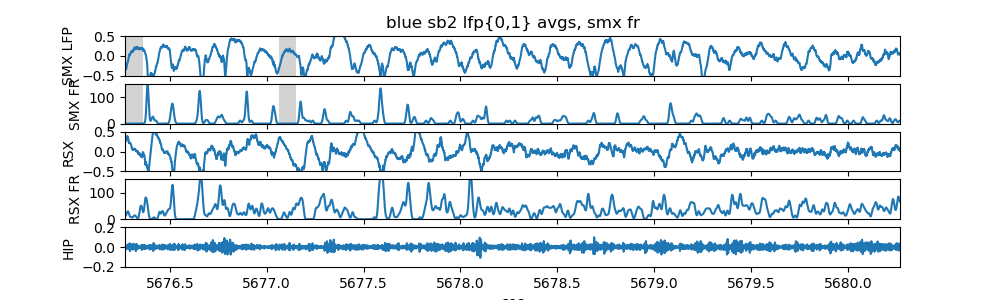

In [5]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 3))
plt.xlim(utils.sample_to_sec(silent_blocks[0][0], smxfr_time), utils.sample_to_sec(silent_blocks[0][0], smxfr_time)+4)  # Arbitrary starting window.

axes[0].plot(time, smx_avg)
axes[0].set_ylabel("SMX LFP")
axes[0].set_ylim((-0.5, 0.5))
axes[0].set_title("blue sb2 lfp{0,1} avgs, smx fr")
for block in silent_blocks:
    rect = Rectangle((utils.sample_to_sec(block[0], smxfr_time), -1), width=(block[1]-block[0])/1000, height=2, facecolor='lightgrey')
    axes[0].add_patch(rect)

axes[1].plot(smxfr_time, smxfr_data)
axes[1].set_ylabel("SMX FR")
axes[1].set_ylim((0, 150))
for block in silent_blocks:
    rect = Rectangle((utils.sample_to_sec(block[0], smxfr_time), -1), width=(block[1]-block[0])/1000, height=150, facecolor='lightgrey')
    axes[1].add_patch(rect)

axes[2].plot(time, rsx_avg)
axes[2].set_ylabel("RSX")
axes[2].set_ylim((-0.5, 0.5))

axes[3].plot(rsxfr_time, rsxfr_data)
axes[3].set_ylabel("RSX FR")
axes[3].set_ylim((0, 150))

axes[4].plot(time, hip)
axes[4].set_ylabel("HIP")
axes[4].set_ylim((-0.2, 0.2))
axes[4].set_xlabel("sec")
axes[4].tick_params(axis="x")

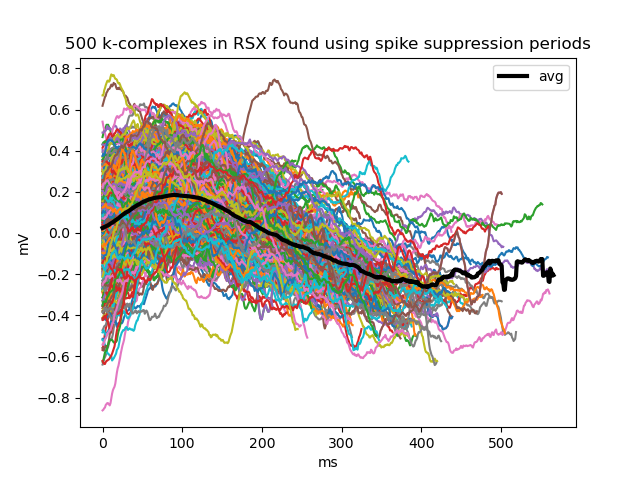

In [12]:
plt.close()
rtol = 1e-7  # Tunable for the search.
k_complexes = []
max_len = 0
for i in np.random.randint(0, len(silent_blocks)-1, size=500):  # Get 500 random ones.
    block = silent_blocks[i]
    # TODO these are very slow, replace with utils.fr_sample2lfp_sample() when fixed.
    s0 = np.argwhere(np.isclose(smxfr_time[block[0]], time, rtol=rtol))[0][0]
    s1 = np.argwhere(np.isclose(smxfr_time[block[1]], time, rtol=rtol))[0][0]
    k_complex = np.squeeze(smx_avg[s0:s1])
    if len(k_complex) > max_len:
        max_len = len(k_complex)
    k_complexes.append(k_complex)
    plt.plot(k_complex)

# Pad arrays to get mean. We pad with NaNs so the right side will look more noisy. Could replace with 0s instead (which also doesn't really make sense).
padded = []
for k_complex in k_complexes:
   padded.append(np.pad(k_complex, (0, max_len-len(k_complex)), constant_values=(np.nan))) 
plt.plot(np.nanmean(np.array(padded), axis=0), lw=3, color="black", label="avg")
plt.title("500 k-complexes in RSX found using spike suppression periods")
plt.ylabel("mV")
plt.xlabel("ms")
ax = plt.gca()
ax.legend()
plt.show()

Now let's try the second method: detecting k-complexes using the motif detector.

In [7]:
query = np.squeeze(smx_avg[utils.sec_to_sample(8388.94, sample_rate, time[0]):utils.sec_to_sample(8389.155, sample_rate, time[0])])
matches = stumpy.match(np.squeeze(query), np.squeeze(smx_avg))

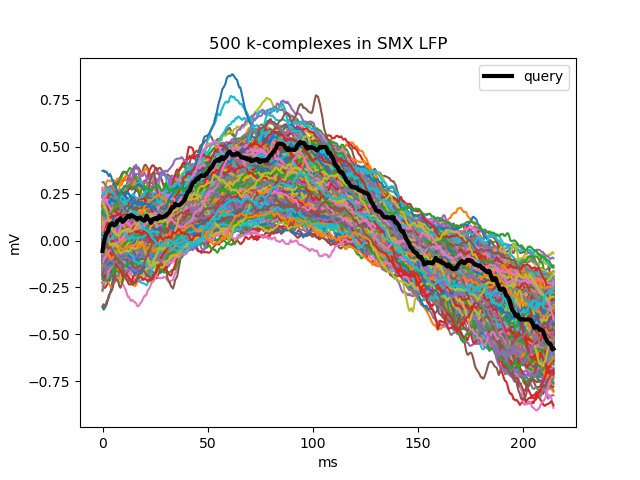

In [8]:
plt.close()
for match in matches[:500]:  # Uses 500 "closest" matches.
    plt.plot(np.arange(0, (len(query))/sample_rate, 1./sample_rate)*1000, smx_avg[match[1]:match[1]+len(query)])
plt.plot(np.arange(0, (len(query))/sample_rate, 1./sample_rate)*1000, query, lw=3, color="black", label="query")
plt.title("500 k-complexes in SMX LFP")
plt.ylabel("mV")
plt.xlabel("ms")
ax = plt.gca()
ax.legend()
plt.show()

In [9]:
# Get all the windows of matching k-complexes, in seconds.
smx_k = []
for match in matches:
    smx_k.append((match[1], match[1]+450))

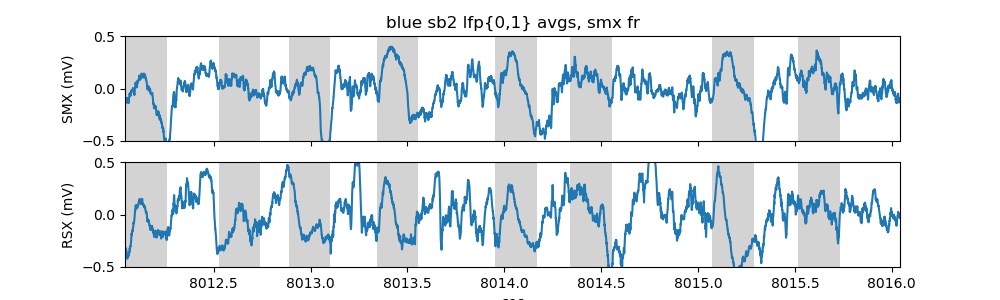

In [10]:
plt.close()
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 3))
plt.xlim(utils.sample_to_sec(smx_k[20][0], time), utils.sample_to_sec(smx_k[20][0], time)+4)  # Set arbitrary window.

axes[0].plot(time, smx_avg)
axes[0].set_ylabel("SMX (mV)")
axes[0].set_ylim((-0.5, 0.5))
axes[0].set_title("blue sb2 lfp{0,1} avgs, smx fr")
for k in smx_k:
    rect = Rectangle((utils.sample_to_sec(
        k[0], time), -1), width=len(query)/sample_rate, height=3, facecolor='lightgrey')
    axes[0].add_patch(rect)

axes[1].plot(time, rsx_avg)
axes[1].set_ylabel("RSX (mV)")
axes[1].set_ylim((-0.5, 0.5))
axes[1].set_xlabel("sec")
axes[1].tick_params(axis="x")
for k in smx_k:
    rect = Rectangle((utils.sample_to_sec(
        k[0], time), -1), width=len(query)/sample_rate, height=3, facecolor='lightgrey')
    axes[1].add_patch(rect)
